In [59]:
%run spot_functions.ipynb
%run gl_functions.ipynb

In [2]:
sdk, robot, id_client, \
robot_state_client, command_client, \
image_client, graph_nav_client, \
world_object_client, manipulation_api_client = initRobot('192.168.50.3')
timeout_sec = 5

In [3]:
lease_client, lease, lease_keep_alive = getLease(robot)

In [90]:
# Initialize Groundlight API

GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'
gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)
detectors = gl.list_detectors()
depthDet = detectors.results[0]
noDepthDet = detectors.results[2]

In [91]:
getBattInfo()

Battery at: 49.0 %. Robot has 2797 seconds left


(49.0, 2797)

In [7]:
success = powerOn(robot)

True


In [294]:
cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [8]:
bdcrc.blocking_selfright(command_client, timeout_sec = timeout_sec)

CommandTimedOutError: Took longer than 5.0 seconds to assure the robot completed self-right.

In [ ]:
bdcrc.blocking_sit(command_client, timeout_sec = timeout_sec)

In [9]:
bdcrc.blocking_stand(command_client, timeout_sec = timeout_sec)

In [36]:
moveRobotRelative(command_client, -0.2, 0, 0)

In [31]:
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

In [289]:
moveTo, lookAt = randomGazeDown()

armOrigin = np.array([0.35,0,0.1])

print(np.round(moveTo,2), np.sum( (moveTo-armOrigin)**2 ) **0.5, np.round(lookAt, 2))

moveToAndLookAt(moveTo,lookAt, True)

time.sleep(0.5)

[0.65 0.33 0.56] 0.6435971592402397 [ 1.35  0.18 -0.6 ]


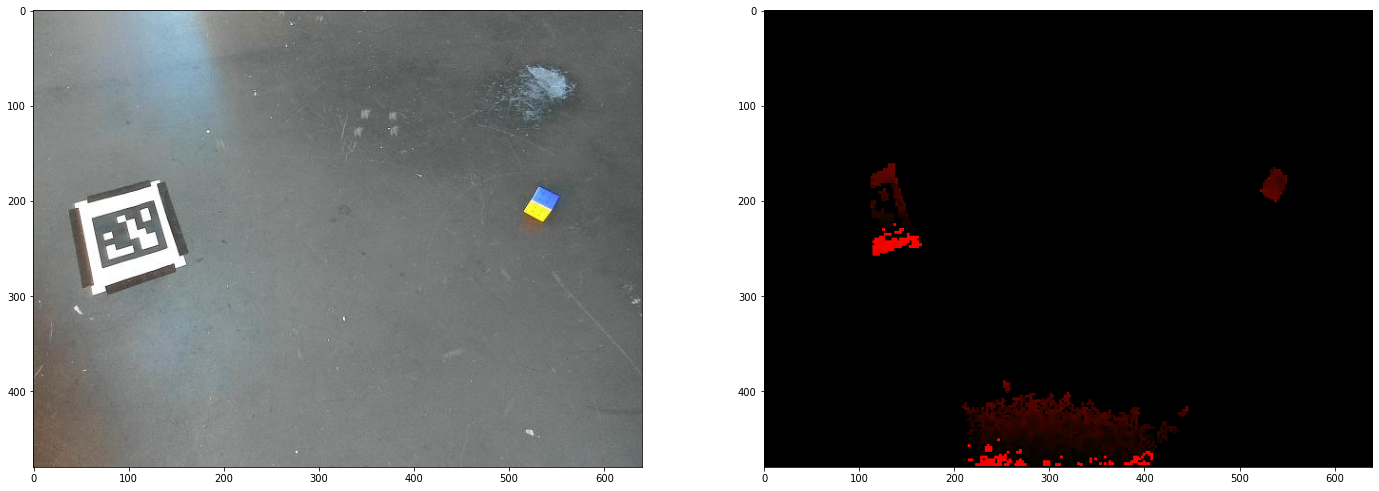

In [290]:
handColorImg, image_response = capHandImage(image_client, 'hand_color_image')
handDepthImg, _ = capHandImage(image_client, 'hand_depth_in_hand_color_frame')

imgZero = np.zeros((handDepthImg.shape[0], handDepthImg.shape[1],1))

handDepthImg = np.concatenate((handDepthImg, imgZero), 2).astype(np.uint8)

fig, ax = plt.subplots(1,2, figsize = (24,9))
ax[0].imshow(handColorImg)
ax[1].imshow(handDepthImg)

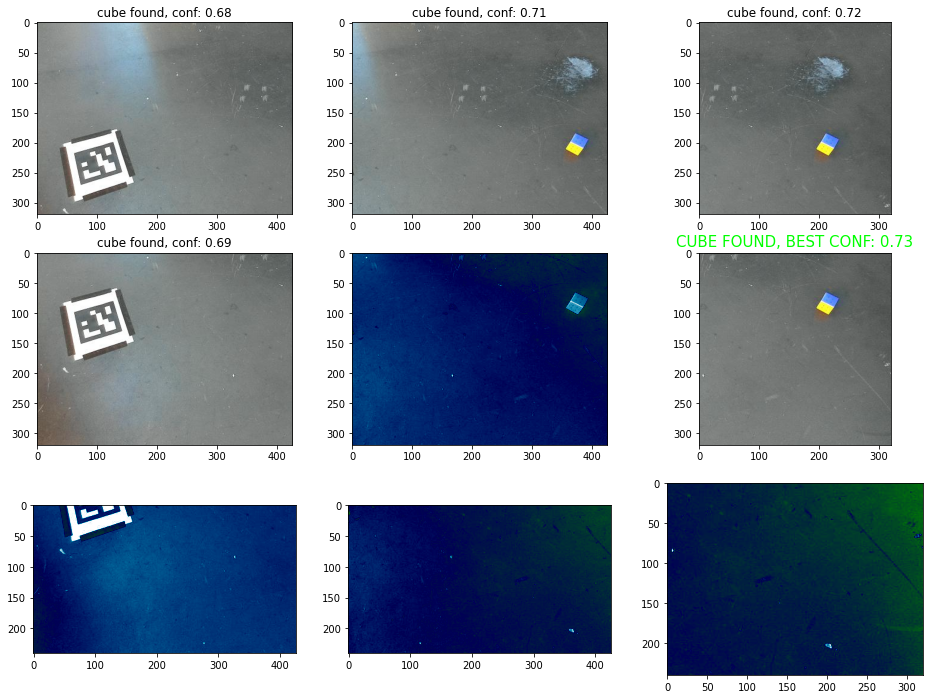

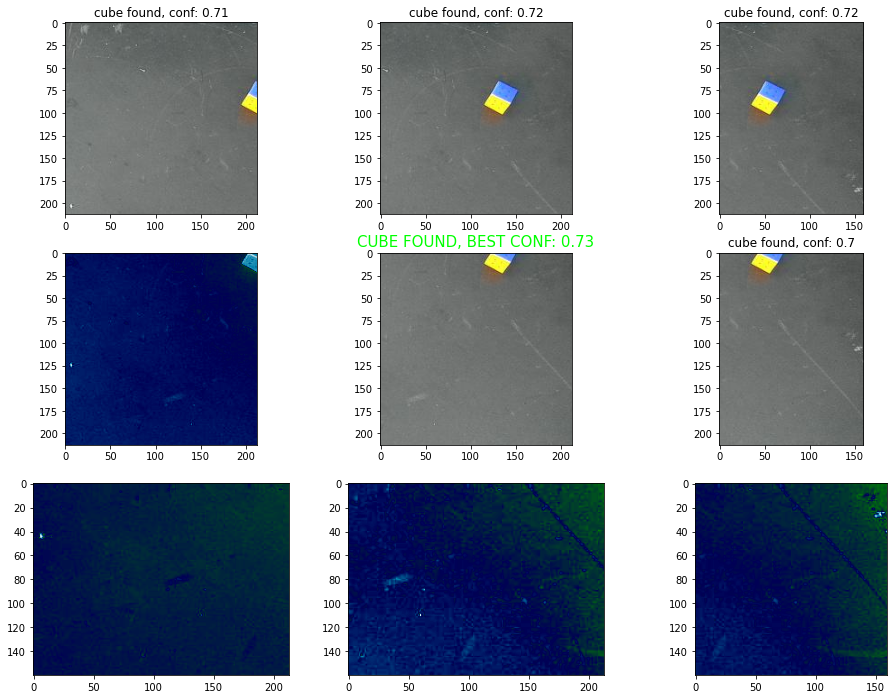

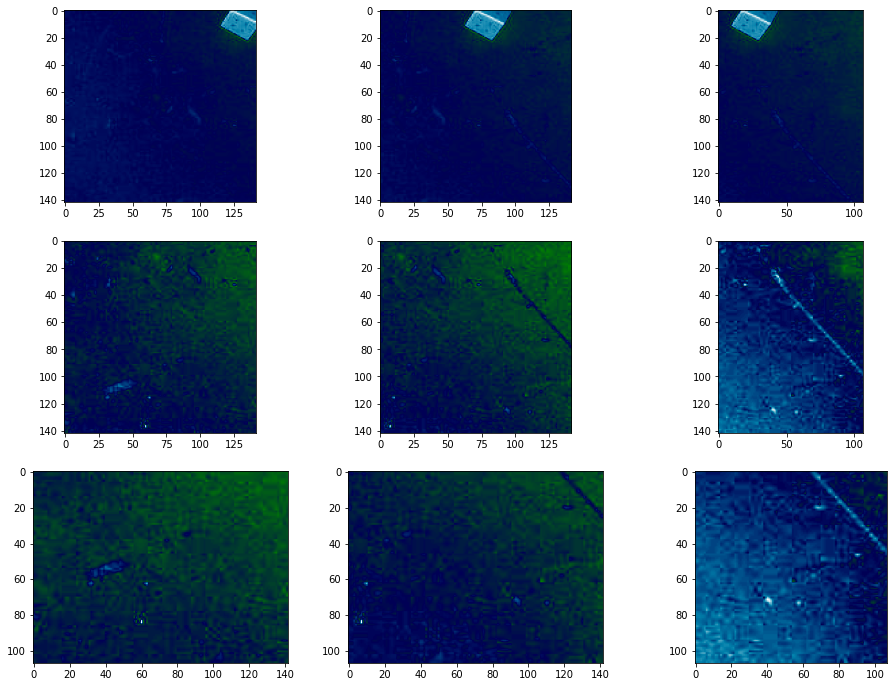

In [291]:
tree = sweepLocalizeColorDepth(det, handColorImg, handDepthImg, verbose = True)

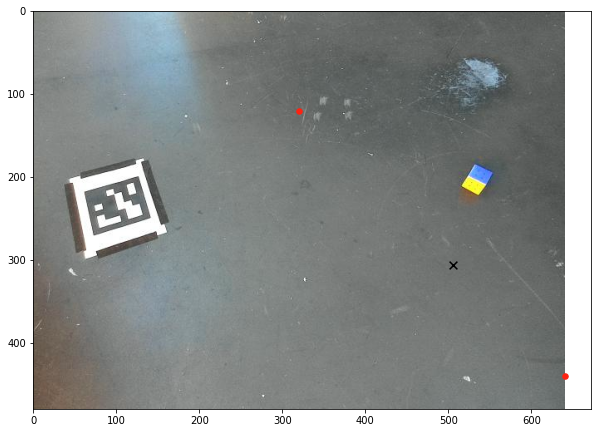

In [292]:
pxLoc = assemblePxTree(tree)
plotTreeOnImage(tree, handColorImg)
plt.show()

In [103]:
def depthVsNoDepth():
    moveTo, lookAt = randomGazeDown()

    #armOrigin = np.array([0.35,0,0.1])

    #print(np.round(moveTo,2), np.sum( (moveTo-armOrigin)**2 ) **0.5, np.round(lookAt, 2))

    moveToAndLookAt(moveTo,lookAt, True)

    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

    time.sleep(0.5)


    handColorImg, image_response = capHandImage(image_client, 'hand_color_image')
    handDepthImg, _ = capHandImage(image_client, 'hand_depth_in_hand_color_frame')

    imgZero = np.zeros((handDepthImg.shape[0], handDepthImg.shape[1],1))

    handDepthImg = np.concatenate((handDepthImg, imgZero), 2).astype(np.uint8)



    print('localizing with no depth')
    start_time_sec = time.time()
    treeNoDepth = sweepLocalize(noDepthDet, handColorImg, verbose = False)
    end_time_sec = time.time()
    print('Localizing cube without depth took', end_time_sec - start_time_sec, 'seconds')

    print('localizing with depth')
    start_time_sec = time.time()
    treeWithDepth = sweepLocalizeColorDepth(depthDet, handColorImg, handDepthImg, verbose = False)
    end_time_sec = time.time()
    print('Localizing cube with depth took', end_time_sec - start_time_sec, 'seconds')

    return handColorImg, handDepthImg, treeNoDepth, treeWithDepth

In [104]:
def plotTreeComparison(handColorImg, handDepthImg, treeNoDepth, treeWithDepth):
    fig, ax = plt.subplots(2,2, figsize = (16,12))

    ax[0,0].imshow(handColorImg)
    ax[0,0].set_title('Original Image', fontsize = 15)
    ax[0,1].imshow(handDepthImg)
    ax[0,1].set_title('Depth Image', fontsize = 15)

    if treeNoDepth is not None:
        plotTreeOnImage(ax[1,0], treeNoDepth, handColorImg)
        ax[1,0].set_title('Localization of cube WITHOUT depth', fontsize = 15)
    if treeWithDepth is not None:
        plotTreeOnImage(ax[1,1], treeWithDepth, handColorImg)
        ax[1,1].set_title('Localization of cube WITH depth', fontsize = 15)
        
    plt.show()

In [108]:
for i in range(10):
    handColorImg, handDepthImg, treeNoDepth, treeWithDepth = depthVsNoDepth()
    plotTreeComparison(handColorImg, handDepthImg, treeNoDepth, treeWithDepth)

localizing with no depth


KeyboardInterrupt: 

In [14]:
def randomGazeDown():    
    armOrigin = np.array([0.35,0,0.1])# NOT EXACT, USED FOR ROUGHLY CALCULATING POINTS OF MAXIMUM REACH
    armLength = 0.7

    armZPos = np.random.uniform(0.2, armLength-0.2)
    armXPos = np.random.uniform(0,(armLength**2 - armZPos**2)**0.5)
    
    maxYPos = (armLength**2 - armXPos**2 - armZPos**2)**0.5
    armYPos = np.random.uniform(-maxYPos, maxYPos)

    moveTo = np.array([armXPos, armYPos, armZPos]) + armOrigin

    lookAt = [np.random.uniform(1, 1.5), 
              np.random.uniform(-0.4,0.4), 
              np.random.uniform(-0.2,-1)]
    return moveTo, lookAt

In [15]:
def randomCubeDrop(command_client):
    randomLookDir = [((np.random.rand() * 2) - 1) * 2, 
                 (((np.random.rand()) * 2) - 1) * 3, 
                 np.random.rand() * (-2)  ]

    moveToAndLookAt([0.8,0,-0.35],randomLookDir, True)
    
    time.sleep(0.5)

    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

    time.sleep(0.5)

    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

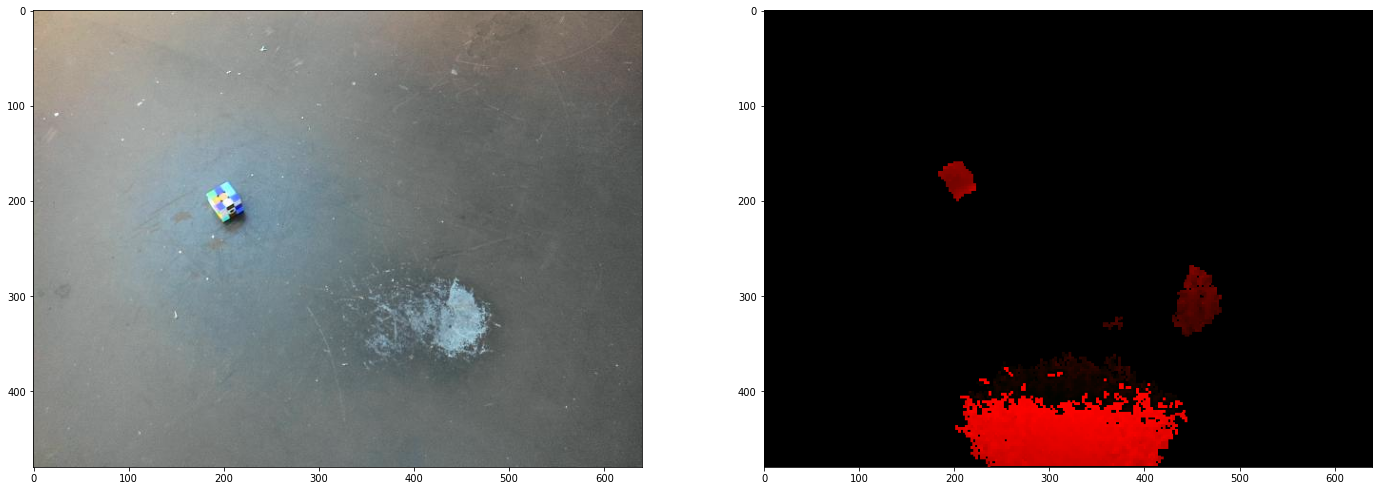

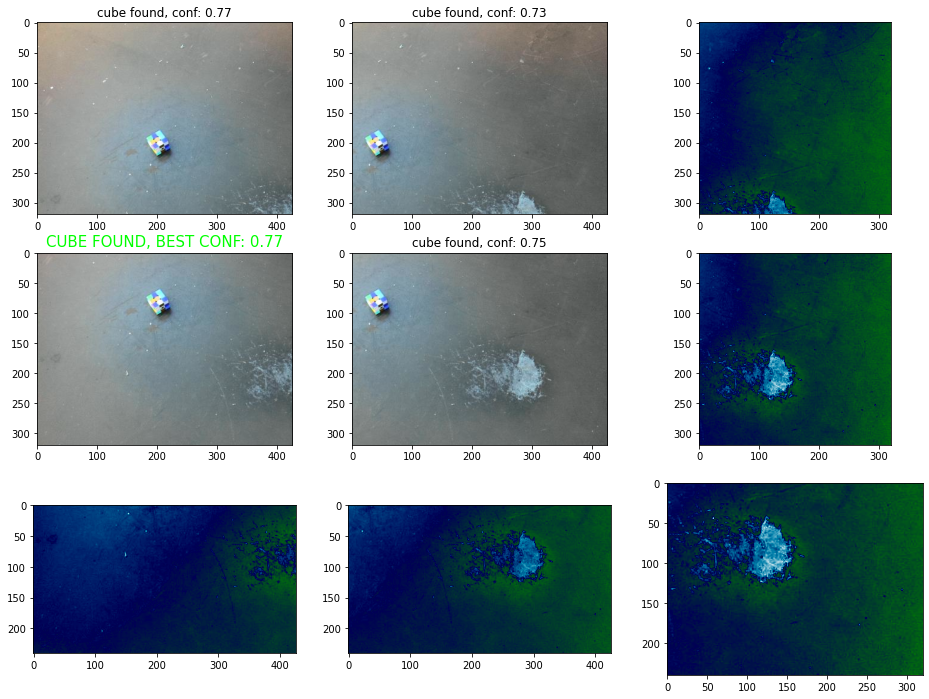

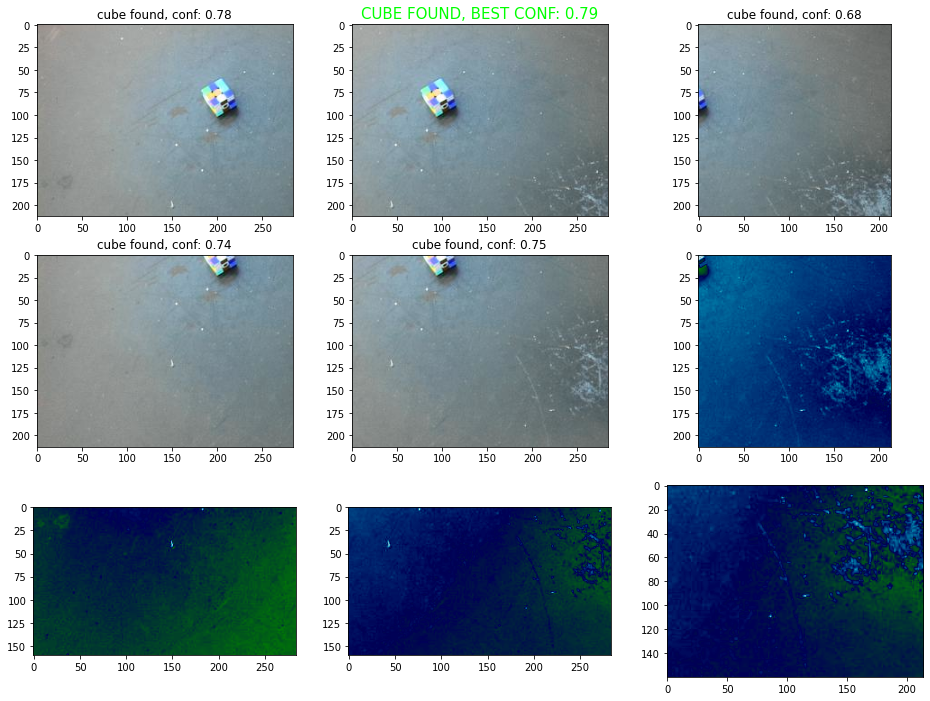

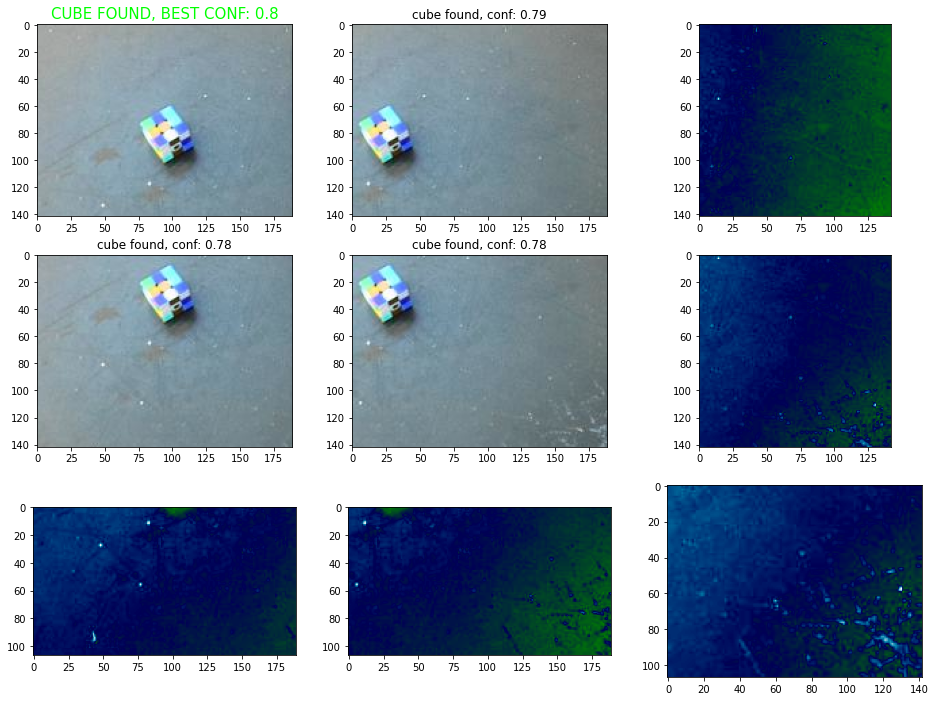

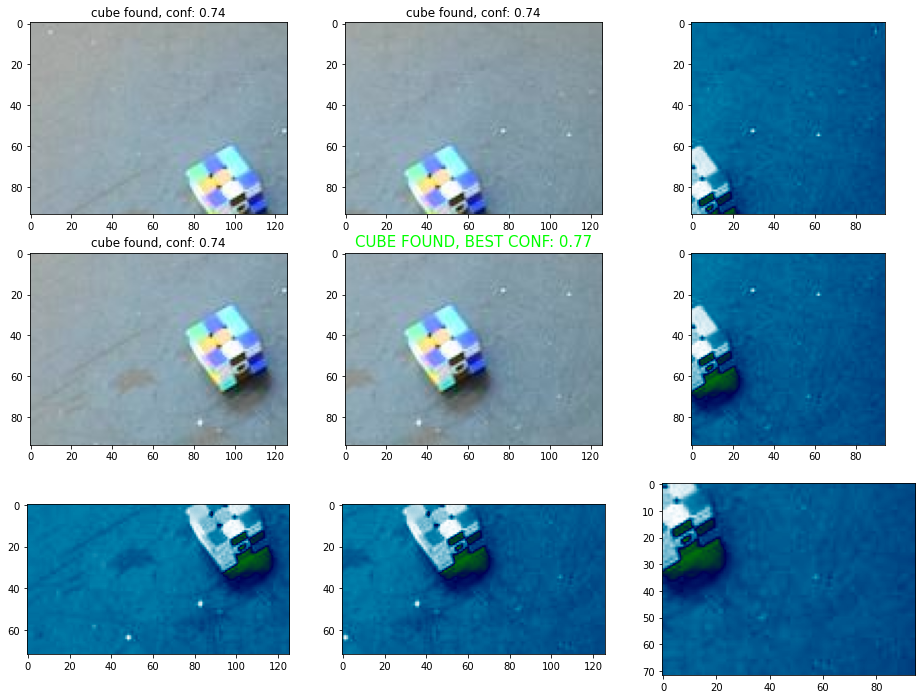

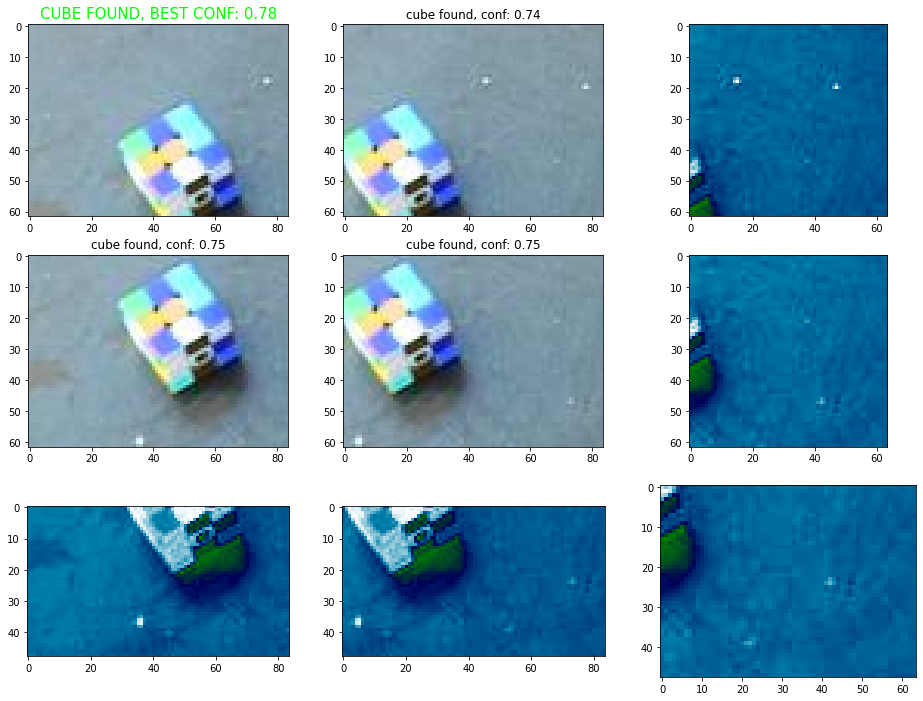

CUBE FOUND, PREPARING TO GRASP


TypeError: plotTreeOnImage() missing 1 required positional argument: 'img'

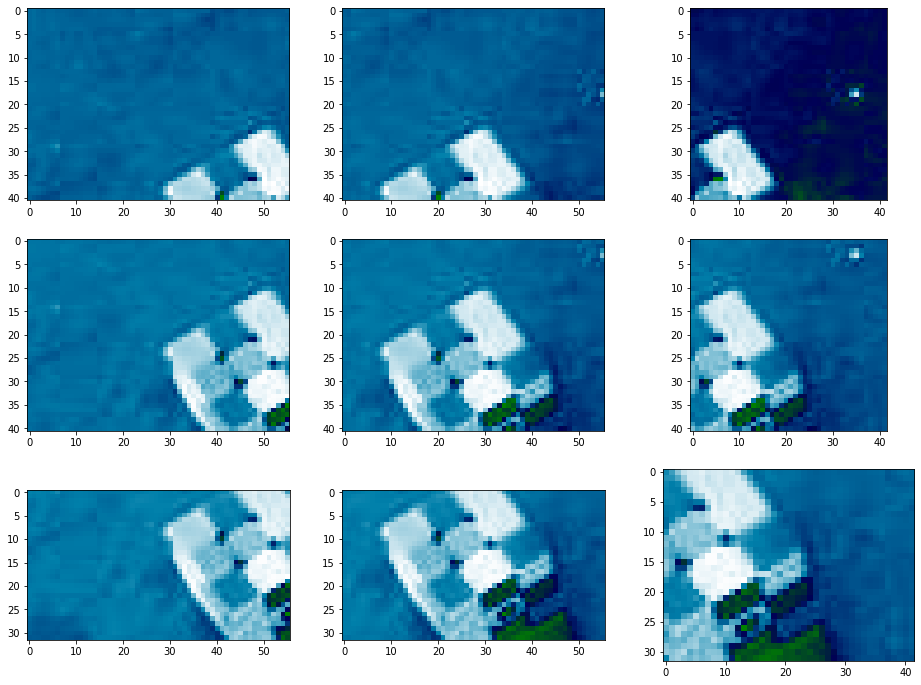

In [107]:
for i in range(6):
    bdcrc.blocking_stand(command_client, timeout_sec = timeout_sec)

    moveTo, lookAt = randomGazeDown()
    
    moveToAndLookAt(moveTo,lookAt, True)
    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
    time.sleep(0.5)

    graph_response = graph_nav_client.clear_graph()

    handColorImg, image_response = capHandImage(image_client, 'hand_color_image')
    handDepthImg, _ = capHandImage(image_client, 'hand_depth_in_hand_color_frame')

    imgZero = np.zeros((handDepthImg.shape[0], handDepthImg.shape[1],1))

    handDepthImg = np.concatenate((handDepthImg, imgZero), 2).astype(np.uint8)

    fig, ax = plt.subplots(1,2, figsize = (24,9))
    ax[0].imshow(handColorImg)
    ax[1].imshow(handDepthImg)
    plt.show()
    
    time.sleep(0.1)
    
    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
    bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = time.time() + 3.0)
    
    time.sleep(1.5)

    tree = sweepLocalizeColorDepth(depthDet, handColorImg, handDepthImg, verbose = True)

    if tree is None:
        print('CUBE NOT FOUND')
        continue
    else:
        print('CUBE FOUND, PREPARING TO GRASP')

    plotTreeOnImage(tree, handColorImg)
    plt.show()

    pxLoc = assemblePxTree(tree)
    pick_vec = geometry_pb2.Vec2(x=pxLoc[0], y=pxLoc[1])

    grasp = manipulation_api_pb2.PickObjectInImage(
        pixel_xy=pick_vec, transforms_snapshot_for_camera=image_response.shot.transforms_snapshot,
        frame_name_image_sensor=image_response.shot.frame_name_image_sensor,
        camera_model=image_response.source.pinhole)

    grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object_in_image=grasp)
    
    response, success = makeGrasp(grasp_request, graph_nav_client)
    if not success:
        print("SPOT FAILS TO MAKE GRASP", response.current_state)
        continue
        
    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
    bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = time.time() + 3.0)
    
    time.sleep(2)
    
    moveRobotRelative(command_client, -0.5, 0, 0)

    
    curState = robot_state_client.get_robot_state()
    wristPosRads = np.abs(curState.kinematic_state.joint_states[-1].position.value)
    
    if wristPosRads < np.pi/36:
        print('GRIPPER IS CLOSED. FAILED TO GRAB CUBE')
        continue
    
    randomCubeDrop(command_client)
    

In [26]:
response, success = makeGrasp(grasp_request, graph_nav_client)

In [28]:
randomCubeDrop(command_client)

In [27]:
response

header {
  request_header {
    request_timestamp {
      seconds: 1656110867
      nanos: 932726016
    }
    client_name: "ASTROspotJetson:8618"
  }
  request_received_timestamp {
    seconds: 1656110975
    nanos: 536700601
  }
  response_timestamp {
    seconds: 1656110975
    nanos: 536712168
  }
  error {
    code: CODE_OK
  }
  request {
    type_url: "type.googleapis.com/bosdyn.api.ManipulationApiFeedbackRequest"
    value: "\n$\n\014\010\223\376\330\225\006\020\200\212\341\274\003\022\024ASTROspotJetson:8618\020\233N"
  }
}
current_state: MANIP_STATE_GRASP_SUCCEEDED
transforms_snapshot_manipulation_data {
  child_to_parent_edge_map {
    key: "gripper_nearest_object"
    value {
      parent_frame_name: "vision"
      parent_tform_child {
        position {
          x: -1.586358458215219
          y: 0.2776023211742506
          z: -0.04897715019077597
        }
        rotation {
          w: 1.0
        }
      }
    }
  }
  child_to_parent_edge_map {
    key: "vision"
    